# Machine Learning

## Imports

In [185]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,Bootstrap
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

ImportError: cannot import name 'Bootstrap'

## Importar dados normalizados

In [186]:
dados = pd.read_csv('C:/Users/lucas/Documents/GitHub/INT/Manufatura Aditiva/Classificação Direção/Dados/Dados tratados.csv')
X = dados[['Tensão na força máxima','Deformação na ruptura']]
y = dados['Plano ID']
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Área Inicial                40 non-null     float64
 1   Módulo elástico             40 non-null     float64
 2   Carga no escoamento         40 non-null     float64
 3   Tensão de escoamento        40 non-null     float64
 4   Dedformação no escoamento   40 non-null     float64
 5   Força máxima                40 non-null     float64
 6   Tensão na força máxima      40 non-null     float64
 7   Deformação na força máxima  40 non-null     float64
 8   Força de ruptura            40 non-null     float64
 9   Deformação na ruptura       40 non-null     float64
 10  Plano                       40 non-null     object 
 11  Plano ID                    40 non-null     int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 3.9+ KB


##  Reamostragem por Bootstrap para compensar o pequeno dataset

In [194]:
def bootstrap_resample(X, n=None):
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

## Ajuste de hiperparâmetros

In [161]:
def get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid, model,w,h,df,plot,annot):
    
    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      cv=kfold)
    best_gs = gs.fit(X_train,y_train)
    n = len(param_grid)
    scores = best_gs.cv_results_['mean_test_score']
    scores = scores.reshape(len(scores),)
    
    if n == 1:
        label = list(param_grid.keys())[0]
        par = list(param_grid.values())[0]
        plt.plot(par,scores)
        plt.ylabel('F1-score')
        plt.xlabel(label)
        plt.show()
        
    if n == 2:
        
        label1,label2 = param_grid.keys()
        par1,par2 = param_grid.values()
        scores_df = pd.DataFrame(columns=par1,index=par2)
        for i in range(len(par1)*len(par2)):
            col = i % len(par1)
            row = i // len(par1)
            scores_df.iloc[row,col] = scores[i]

        scores_df = scores_df.astype(float)
        if df:
            print(scores_df)
        if plot:
            fig= plt.figure(figsize=(w,h))
            heatmap = sns.heatmap(scores_df,annot=annot)        
            plt.xlabel(label1)
            plt.ylabel(label2)
            plt.show()
    return best_gs.best_params_

X = dados[['Tensão na força máxima','Deformação na ruptura']]
y = dados['Plano ID']

n_folds = 4
test_size = 0.35

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size)
kfold = KFold(n_folds,shuffle=True,random_state=42)

## `K` para o KNN

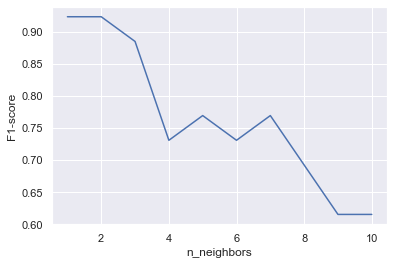

1

In [162]:
min_k, max_k = 1,10
ks = [i for i in range(min_k,max_k+1)]
param_grid_knn = {'n_neighbors': ks}
k_opt = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid_knn, KNeighborsClassifier(),8,6,False,True,True)['n_neighbors']
k_opt

## `alpha` para o SGD

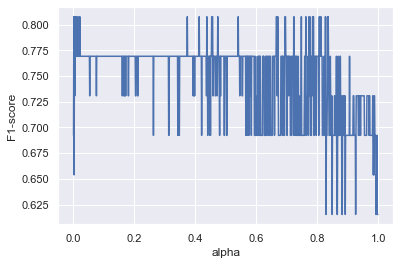

{'alpha': 0.002}

In [167]:
alphas = np.arange(0.001,1.0, 0.001).round(3)

param_grid={'alpha': alphas}
get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid,SGDClassifier(penalty='l2',random_state=42),10,6,False,True,True)

## `C` e `gama` para o SVM. `grau` foi mantido em _auto_ 

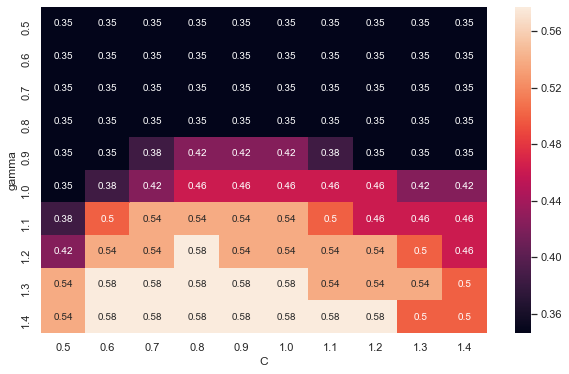

{'C': 1.2, 'gamma': 0.8}

In [179]:
Cs = np.arange(.5,1.5,.1)
Cs = Cs.round(1)
gammas = np.arange(.5,1.5,.1)
gammas = gammas.round(1)

param_grid={'C': Cs, 'gamma': gammas}
get_hiperparams(X_train,X_test,y_train,y_test,5,param_grid,SVC(random_state=42,kernel='sigmoid'),10,6,False,True,True)

## `max_depth` para Árvore de Decisão

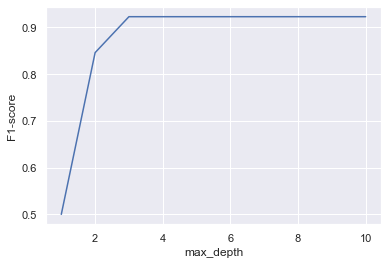

In [182]:
tree_score = []
max_depth = 10
depths = [i for i in range(1,max_depth+1)]
param_grid = {'max_depth':depths}
max_depth_opt = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid,DecisionTreeClassifier(random_state=42,),10,6,False,True,True)['max_depth']

## Separando Treino e Teste para diferentes splits, usando cross fold validation. 

In [53]:
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

knn_score = 0.0
sgd_score = 0.0
svc_score = 0.0
tree_score = 0.0

for train_index, test_index in sss.split(X, y):    
    X_train,X_test,y_train,y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

    #KNN
    knn = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(n_neighbors=5))
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    knn_score += f1_score(y_test,pred_knn,average='weighted',pos_label="Plano ID")
    
    #SGD
    sgd = make_pipeline(StandardScaler(),
                        SGDClassifier(random_state=42,penalty='l2',alpha=0.004))
    sgd.fit(X_train, y_train)
    pred_sgd = sgd.predict(X_test)
    sgd_score += f1_score(y_test,pred_sgd,average='weighted',pos_label="Plano ID")
    
    #SVC
    svc = make_pipeline(StandardScaler(),
                        SVC(random_state=42,kernel='sigmoid',gamma='auto'))
    svc.fit(X_train,y_train)
    pred_svc = svc.predict(X_test)
    svc_score += f1_score(y_test,pred_svc,average='weighted',pos_label="Plano ID")
    
    #Decision Trees
    tree = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier(random_state=42,max_depth=max_depth_opt))

    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    tree_score += f1_score(y_test,pred_tree,average='weighted',pos_label="Plano ID")
    
knn_score /= float(n_splits)
sgd_score /= float(n_splits)
svc_score /= float(n_splits)
tree_score /= float(n_splits)

print(f'F1 score for KNN={knn_score}, SGD={sgd_score}, SVC={svc_score}, Decision Trees={tree_score}')

F1 score for KNN=0.978835978835979, SGD=0.9680423280423281, SVC=0.9682539682539684, Decision Trees=0.9092021404521407


## Plotar resultados

### KNN

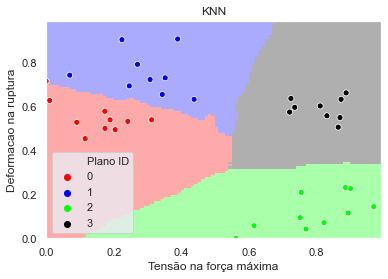

In [45]:
n_neighbors = 4
h = .01

x_min, x_max = X.iloc[:,0].min(), X.iloc[:,0].max() 
y_min, y_max = X.iloc[:,1].min(), X.iloc[:,1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensão na força máxima', y = 'Deformação na ruptura', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensão na força máxima')
plt.ylabel('Deformacao na ruptura')
plt.title('KNN')
plt.show()

### SGD

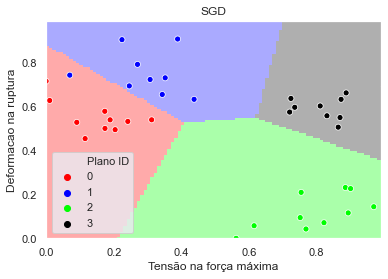

In [496]:
Z = sgd.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensão na força máxima', y = 'Deformação na ruptura', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensão na força máxima')
plt.ylabel('Deformacao na ruptura')
plt.title('SGD')
plt.show()

### SVM

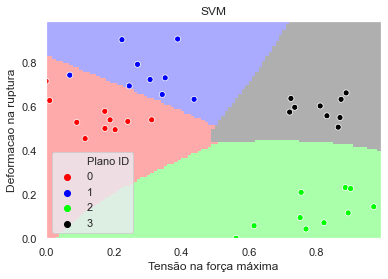

In [497]:
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensão na força máxima', y = 'Deformação na ruptura', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensão na força máxima')
plt.ylabel('Deformacao na ruptura')
plt.title('SVM')
plt.show()

### Árvore de Decisão

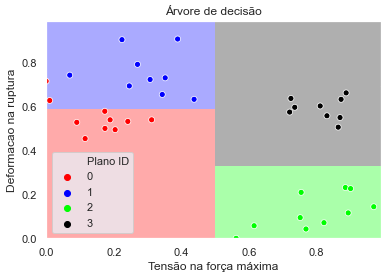

In [46]:
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF','#AAFFAA','#AFAFAF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF','#00FF00','#000000'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.scatterplot(x = 'Tensão na força máxima', y = 'Deformação na ruptura', data= dados, hue = 'Plano ID', palette=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Tensão na força máxima')
plt.ylabel('Deformacao na ruptura')
plt.title('Árvore de decisão')
plt.show()